In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img

%matplotlib inline

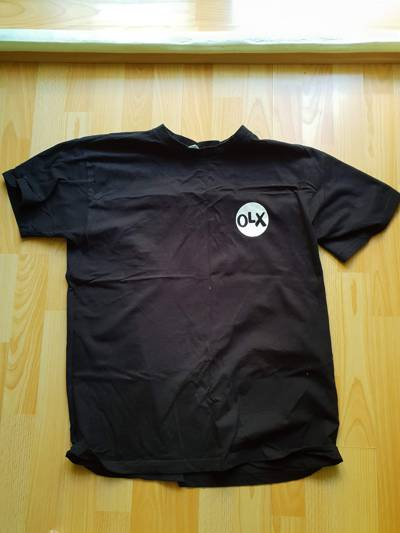

In [9]:
path = './clothing-dataset-small/train/t-shirt'
name = '5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg'
fullname = f'{path}/{name}'
load_img(fullname)

In [10]:
img = load_img(fullname, target_size=(299, 299))

In [12]:
x = np.array(img)
x.shape # 3 indicates an RGB photo

(299, 299, 3)

## Pre-trained convolutional neural networks

In [13]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

In [14]:
model = Xception(weights='imagenet', input_shape=(299, 299, 3))

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step


In [25]:
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [26]:
X = preprocess_input(X)

In [27]:
pred = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


In [28]:
decode_predictions(pred)

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


[[('n03595614', 'jersey', np.float32(0.68196255)),
  ('n02916936', 'bulletproof_vest', np.float32(0.038140047)),
  ('n04370456', 'sweatshirt', np.float32(0.034324896)),
  ('n03710637', 'maillot', np.float32(0.011354239)),
  ('n04525038', 'velvet', np.float32(0.0018453641))]]

## Transfer learning

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [43]:
# Create an ImageDataGenerator for training data
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load the training dataset from the specified directory
train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train',
    target_size=(150, 150), # Resize images to 150x150
    batch_size=32
)

Found 3068 images belonging to 10 classes.


In [31]:
train_ds.class_indices

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

In [39]:
X, y = next(train_ds)
y[:5]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [42]:
# Create an ImageDataGenerator for validation data
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load the validation dataset from the specified directory
val_ds = val_gen.flow_from_directory(
    './clothing-dataset-small/validation',
    target_size=(150, 150), # Resize images to 150x150
    batch_size=32,
    shuffle=False # Do not shuffle data; ensures reproducibility
)

Found 341 images belonging to 10 classes.


In [44]:
# Load the pre-trained Xception model
base_model = Xception(
    weights='imagenet',
    include_top=False, # Exclude the top (fully connected) layers for custom training
    input_shape=(150, 150, 3)
)

# Freeze the base model's layers
# This prevents the weights of the pre-trained layers from being updated during training
base_model.trainable = False

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step


In [46]:
# Define the input layer for the model
# The input shape matches the shape of the images (150x150 pixels with 3 color channels)
inputs = keras.Input(shape=(150, 150, 3))

# Pass inputs through the pre-trained Xception model without updating its weights
base = base_model(inputs, training=False)

# Apply global average pooling to the output of the base model
# This reduces the spatial dimensions of the feature maps to a single vector per feature map
vectors = keras.layers.GlobalAveragePooling2D()(base)

# Dense layer: Adds a fully connected layer with 10 outputs (number of classes)
outputs = keras.layers.Dense(10)(vectors)

# Combine the input and output layers into a final model
model = keras.Model(inputs, outputs)

In [48]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [49]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10


/Users/yasaman/anaconda3/envs/cloths_classification/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 54s 545ms/step - accuracy: 0.5847 - loss: 1.6822 - val_accuracy: 0.7830 - val_loss: 0.8318
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 53s 557ms/step - accuracy: 0.8313 - loss: 0.4966 - val_accuracy: 0.8094 - val_loss: 0.7941
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 54s 562ms/step - accuracy: 0.8744 - loss: 0.3519 - val_accuracy: 0.8152 - val_loss: 0.7722
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 50s 520ms/step - accuracy: 0.9101 - loss: 0.2529 - val_accuracy: 0.7889 - val_loss: 0.8880
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 50s 518ms/step - accuracy: 0.9387 - loss: 0.1866 - val_accuracy: 0.8006 - val_loss: 0.8758
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 49s 508ms/step - accuracy: 0.9575 - loss: 0.1289 - val_accuracy: 0.7859 - val_loss: 1.0951
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 49s 509ms/step - accuracy: 0.9681 - loss: 0.1072 - val_accuracy: 0.7771 - val_loss: 1.1275
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 49s 509ms/step - accuracy: 0.9812 - loss: 0.0656 - val_accuracy: 0.812

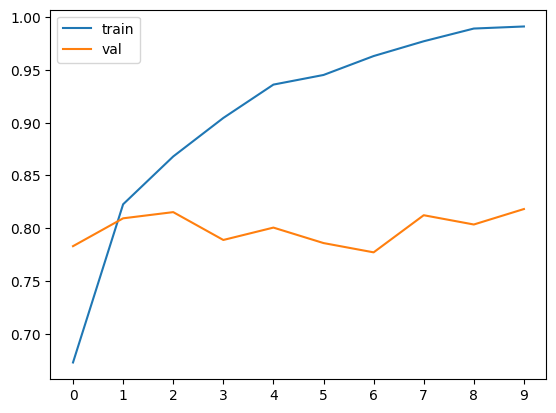

In [51]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

## Adjusting the learning rate

In [52]:
def make_model(learning_rate=0.01):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(10)(vectors)
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [54]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history

    print()
    print()

0.0001
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 55s 557ms/step - accuracy: 0.3053 - loss: 2.0518 - val_accuracy: 0.5191 - val_loss: 1.5435
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 50s 523ms/step - accuracy: 0.5447 - loss: 1.4477 - val_accuracy: 0.6070 - val_loss: 1.2192
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 51s 530ms/step - accuracy: 0.6488 - loss: 1.1355 - val_accuracy: 0.6774 - val_loss: 1.0450
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 49s 509ms/step - accuracy: 0.6751 - loss: 1.0211 - val_accuracy: 0.7097 - val_loss: 0.9382
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 55s 575ms/step - accuracy: 0.7193 - loss: 0.9207 - val_accuracy: 0.7419 - val_loss: 0.8632
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 53s 543ms/step - accuracy: 0.7254 - loss: 0.8435 - val_accuracy: 0.7625 - val_loss: 0.8150
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 51s 532ms/step - accuracy: 0.7488 - loss: 0.7807 - val_accuracy: 0.7742 - val_loss: 0.7745
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 586ms/step - accuracy: 0.7562 - loss: 0.7545 - v

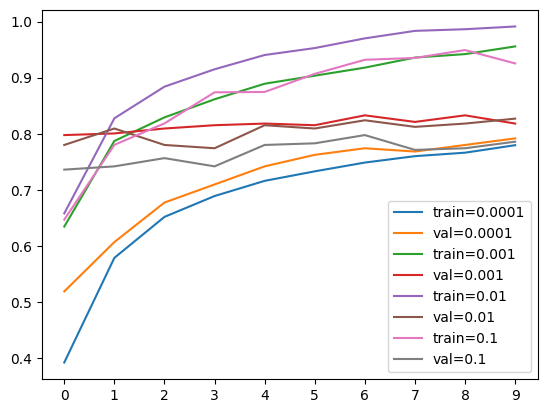

In [55]:
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

In [56]:
del scores[0.1]
del scores[0.0001]

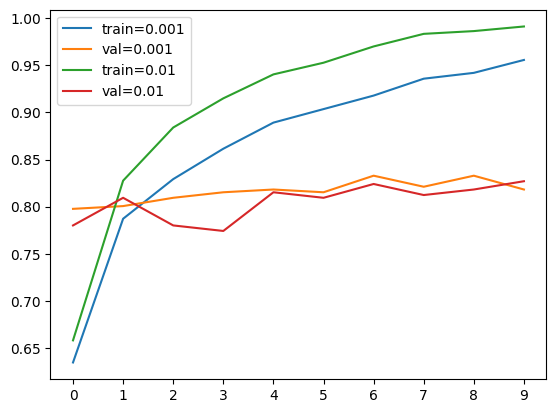

In [60]:
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

In [58]:
#Choosing the best lr
learning_rate = 0.001

## Checkpointing